<a href="https://colab.research.google.com/github/ishikaarora/Air-Quality-Prediction-Regression/blob/master/cifar_model_transfer_attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
cifar10_mean = [0.49139968 , 0.48215841 , 0.44653091]
cifar10_std = [0.24703223,  0.24348513 , 0.26158784]

In [0]:
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean,cifar10_std)
])

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform= transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 84170757.68it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # print(inp.shape)
    inp = cifar10_std * inp + cifar10_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [0]:
class mymodel(nn.Module):
    """Custom Model"""

    def __init__(self, in_features, hidden_dim, n_classes):
        """Custom Model Builder."""
        super(mymodel, self).__init__()
        
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, n_classes)
   
  
    def forward(self, images):
        """Perform forward."""
        
        images_vec = images.view(images.size(0), -1)
        hidden_out = F.relu(self.fc1(images_vec))
        hidden_out = F.relu(self.fc2(hidden_out))
        scores = self.fc3(hidden_out)

        return scores

In [0]:
model = torch.load("mymodel.pt", map_location=torch.device(device))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [0]:
def calculate_accuracy(model,loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    return (correct/total)*100, total

In [0]:
criterion = nn.CrossEntropyLoss()

acc, data_size = calculate_accuracy(model, testloader)
print(acc, data_size)

90.36 10000


### Transfer attack from pretrained model

In [0]:
proxy_model = torch.load("myproxymodel_resnet.pt", map_location=torch.device(device))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in proxy_model.parameters():
    param.requires_grad = False

In [0]:
# proxy_model

In [0]:
criterion = nn.CrossEntropyLoss()

proxy_acc, data_size = calculate_accuracy(proxy_model, testloader)
print(proxy_acc, data_size)

79.46 10000


In [0]:
# FGSM Gradient attack code
def gradient_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def transfer_attack(proxy_model, data, target, **kwargs):
    # Attack setup
    loss_fn = kwargs.get('loss_fn', nn.CrossEntropyLoss())
    epsilon = kwargs.get('epsilon', 0.15)
    data.requires_grad = True
    
    proxy_output = proxy_model(data)
    # Calculate the loss, forward pass
    loss = loss_fn(proxy_output, target)
    # Zero all existing gradients
    proxy_model.zero_grad()
    # Calculate gradients of model in backward pass
    loss.backward()
    # Collect datagrad
    data_grad = data.grad.data
    
    # Call FGSM Attack
    perturbed_data = gradient_attack(data, epsilon, data_grad)
    
    return perturbed_data

In [0]:
def test_attack( model, proxy_model, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # Send the data and label to the device
        data = data.to(device)
        target = target.to(device)
        
        # Generate transfer attack adversarial samples
        kwargs = {'loss_fn': nn.CrossEntropyLoss(), 'epsilon': epsilon}
        
        # Call Transfer Attack
        perturbed_data = transfer_attack(proxy_model, data, target, **kwargs)
        
        # Re-classify the perturbed image
        with torch.no_grad():
          outputs = model(perturbed_data)

        _,predicted = torch.max(outputs.data,1)
        correct+=(predicted==target).sum().item()
        total+=target.size(0)
        
    # Calculate final accuracy for this epsilon
    final_acc = correct/total
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy
    return final_acc

In [0]:
accuracies = []
# examples = []
epsilons = [0,0.05,0.1,0.15,0.2,0.25,0.3]
# Run test for each epsilon
criterion = nn.CrossEntropyLoss()
for eps in epsilons:
    acc = test_attack(model, proxy_model, testloader, eps)
    accuracies.append(acc)
    # examples.append(ex)

Epsilon: 0	Test Accuracy = 9036 / 10000 = 0.9036
Epsilon: 0.05	Test Accuracy = 4889 / 10000 = 0.4889
Epsilon: 0.1	Test Accuracy = 2863 / 10000 = 0.2863
Epsilon: 0.15	Test Accuracy = 1889 / 10000 = 0.1889
Epsilon: 0.2	Test Accuracy = 1519 / 10000 = 0.1519
Epsilon: 0.25	Test Accuracy = 1263 / 10000 = 0.1263
Epsilon: 0.3	Test Accuracy = 1059 / 10000 = 0.1059


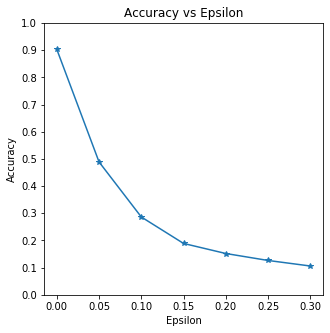

In [0]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
adv_images = transfer_attack(proxy_model, images, labels)

In [0]:
outputs = model(adv_images)
_,predicted = torch.max(outputs.data,1)

In [0]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

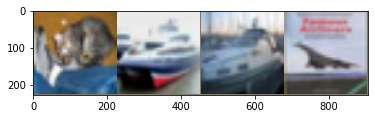

  cat         ship         ship        plane


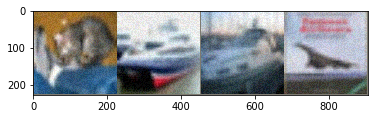

  cat         bird          cat         bird


In [0]:
imshow(torchvision.utils.make_grid(images.detach().cpu()))
print('        '.join('%5s'%classes[labels[j]] for j in range(4)))

imshow(torchvision.utils.make_grid(adv_images.detach().cpu()))
print('        '.join('%5s'%classes[predicted[j]] for j in range(4)))
# adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
# adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

### Try existing pretrained models

In [0]:
# Download and load the pretrained SqueezeNet model.
proxy_model = torchvision.models.squeezenet1_1(pretrained=True)
proxy_model = proxy_model.to(device)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in proxy_model.parameters():
    param.requires_grad = False

### Try Kireeti's CNN model as proxy

In [0]:
class CNN(nn.Module):
    """CNN."""

    def __init__(self):
        """CNN Builder."""
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [0]:
# proxy_model = CNN()
# proxy_model.load_state_dict(torch.load("cifar10_76"))
# proxy_model.eval()
# proxy_model = proxy_model.to(device)

### Try Fooling image function

In [0]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    
    model.eval()
    
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone()
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    X_fooling_var.to(device)
    
    # We will fix these parameters for everyone so that there will be 
    # comparable outputs
    
    learning_rate = 10 # learning rate is 1
    max_iter = 100 # maximum number of iterations
    
    for it in range(max_iter):

    ##############################################################################
    # Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    ##############################################################################
        check_freq = 1
#         model.zero_grad()
        output = model(X_fooling_var)
        
        score, pred = torch.max(output,dim=1) 
        
        score_y = output[:,target_y]
        score_y.backward()
        
        if it % check_freq == 0:
            print("Iteration: ", it)
            print("Predicted Class: {}, \t Predicted Class Score: {}".format(pred[0], score[0]))
            print("Target Class: {}, \t Target Class Score: {}".format(target_y, score_y[0]))
       
        if pred[0] != target_y:
            grad_x = X_fooling_var.grad
            # Check normalization??
            norm_grad = torch.norm(grad_x)**2
            dx = learning_rate * grad_x / norm_grad
            X_fooling_var.data += dx
            X_fooling_var.grad.zero_()

        else:
            break
        
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    
    X_fooling = X_fooling_var.data
    
    return X_fooling

In [0]:
idx = 0
target_y = 6 # target label. Change to a different label to see the difference.

image, label = testset[idx:idx+1]

# X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
# X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

X_fooling = make_fooling_image(image, target_y, proxy_model)
scores = model(Variable(X_fooling))

if target_y == scores.data.max(1)[1][0]: 
    print('Fooled the model!')
else:
    print('The model is not fooled!')

TypeError: ignored